# Penalties in Practice: How Soft Constraints Work

This notebook demonstrates how **penalties** are used to handle soft constraints and preferences in prescriptive models.

Understanding penalties helps you:
- Encode business preferences as soft constraints with penalty functions
- See how penalty values affect model solutions
- Interpret when and why penalties are incurred
- Make informed tradeoffs between preferences and costs


## Key Concepts

**Penalties** represent the cost of violating a preference:
- They allow models to make tradeoffs between competing goals
- Higher penalties mean the preference is more important
- Lower penalties mean the preference is less important
- Penalties make tradeoffs explicit and quantifiable

**Soft Constraints** use penalties:
- Can be violated, but with a cost
- Represent "we prefer" rather than "we must"
- Examples: Minimize overtime, prefer local suppliers, maintain service levels

**Critical insight**: Penalties don't mean the model failed. They show that the model made tradeoffs to balance multiple goals. Understanding penalties helps you interpret why the model chose one solution over another.


## Scenario: Staffing Decision with Overtime Penalty

You manage a call center and need to schedule staff for the upcoming week. You have:

**Hard constraints** (must satisfy):
- Minimum 8 staff must be on duty at all times (legal requirement)
- Budget cannot exceed $8,000 per week

**Soft constraints** (preferences with penalties):
- Prefer to minimize overtime costs (penalty: $50 per overtime hour)
- Prefer to keep schedule changes minimal (penalty: $30 per schedule change)

**Decision**: How many staff to schedule for each shift, and when to use overtime?


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Set Up the Problem

Define shifts, costs, and constraints:


In [3]:
# Problem setup
shifts = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
n_shifts = len(shifts)
regular_rate = 30  # $ per hour
overtime_rate = 45  # $ per hour

# HARD CONSTRAINTS (must be satisfied)
min_staffing = 8  # Minimum staff required (legal requirement)
max_budget = 8000  # Maximum budget (cannot exceed)

# SOFT CONSTRAINT PENALTIES (preferences)
penalty_per_overtime_hour = 50  # Penalty for each hour of overtime
penalty_per_schedule_change = 30  # Penalty for each schedule change from previous week

# Previous week's schedule (for measuring changes)
previous_schedule = [10, 10, 12, 12, 10, 8, 8]  # Staff hours per shift last week

print("PROBLEM SETUP")
print("=" * 70)
print(f"Shifts: {shifts}")
print(f"Regular rate: ${regular_rate}/hour")
print(f"Overtime rate: ${overtime_rate}/hour")
print(f"Minimum staffing: {min_staffing} staff (hard constraint)")
print(f"Maximum budget: ${max_budget} (hard constraint)")
print(f"Overtime penalty: ${penalty_per_overtime_hour}/hour (soft constraint)")
print(f"Schedule change penalty: ${penalty_per_schedule_change}/change (soft constraint)")


PROBLEM SETUP
Shifts: ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
Regular rate: $30/hour
Overtime rate: $45/hour
Minimum staffing: 8 staff (hard constraint)
Maximum budget: $8000 (hard constraint)
Overtime penalty: $50/hour (soft constraint)
Schedule change penalty: $30/change (soft constraint)


## Step 4: Build Model with Penalties

Create a model that includes penalties for violating soft constraints:


In [4]:
# Create model
model = LpProblem("Staffing_With_Penalties", LpMinimize)

# Decision variables
regular_hours = [LpVariable(f"regular_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
overtime_hours = [LpVariable(f"overtime_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
schedule_changes = [LpVariable(f"change_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]

# Calculate total regular cost and overtime cost
total_regular_cost = lpSum([regular_rate * regular_hours[i] for i in range(n_shifts)])
total_overtime_cost = lpSum([overtime_rate * overtime_hours[i] for i in range(n_shifts)])
total_labor_cost = total_regular_cost + total_overtime_cost

# Calculate penalties
total_overtime_penalty = lpSum([penalty_per_overtime_hour * overtime_hours[i] for i in range(n_shifts)])
total_change_penalty = lpSum([penalty_per_schedule_change * schedule_changes[i] for i in range(n_shifts)])
total_penalties = total_overtime_penalty + total_change_penalty

# Objective: Minimize total cost (labor + penalties)
model += total_labor_cost + total_penalties

# HARD CONSTRAINTS (must be satisfied)
for i in range(n_shifts):
    model += regular_hours[i] + overtime_hours[i] >= min_staffing, f"Min_Staffing_{shifts[i]}"

model += total_labor_cost <= max_budget, "Budget_Limit"

# SOFT CONSTRAINTS (preferences with penalties)
# Penalty for overtime is already in objective (overtime_hours * penalty_per_overtime_hour)
# Penalty for schedule changes: measure deviation from previous schedule
for i in range(n_shifts):
    total_hours = regular_hours[i] + overtime_hours[i]
    # Schedule change is absolute difference from previous schedule
    model += schedule_changes[i] >= total_hours - previous_schedule[i], f"Change_Up_{shifts[i]}"
    model += schedule_changes[i] >= previous_schedule[i] - total_hours, f"Change_Down_{shifts[i]}"

# Solve
model.solve()

# Get solution
solution = {}
for i in range(n_shifts):
    reg = value(regular_hours[i])
    ot = value(overtime_hours[i])
    total = reg + ot
    change = value(schedule_changes[i])
    labor_cost = value(regular_rate * reg + overtime_rate * ot)
    overtime_pen = value(penalty_per_overtime_hour * ot)
    change_pen = value(penalty_per_schedule_change * change)
    
    solution[shifts[i]] = {
        'Regular Hours': reg,
        'Overtime Hours': ot,
        'Total Hours': total,
        'Change from Previous': change,
        'Labor Cost': labor_cost,
        'Overtime Penalty': overtime_pen,
        'Change Penalty': change_pen
    }

total_labor = value(total_labor_cost)
total_pen = value(total_penalties)
total_cost = total_labor + total_pen

solution_df = pd.DataFrame(solution).T
print("SOLUTION: Staffing with Penalties")
print("=" * 70)
display(solution_df.round(2))
print(f"\nTotal Labor Cost: ${total_labor:,.2f}")
print(f"Total Penalties: ${total_pen:,.2f}")
print(f"Total Cost (Labor + Penalties): ${total_cost:,.2f}")
print(f"\nBreakdown of Penalties:")
print(f"  - Overtime penalty: ${value(total_overtime_penalty):,.2f}")
print(f"  - Schedule change penalty: ${value(total_change_penalty):,.2f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/3223300b9ddc4a14b22207a8acb205cd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/3223300b9ddc4a14b22207a8acb205cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27 COLUMNS
At line 119 RHS
At line 142 BOUNDS
At line 143 ENDATA
Problem MODEL has 22 rows, 21 columns and 70 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 22 (0) rows, 21 (0) columns and 70 (0) elements
Perturbing problem by 0.001% of 95 - largest nonzero change 0.00036300264 ( 0.0012100088%) - largest zero change 0
0  Obj 0 Primal inf 126 (14)
14  Obj 2100.0188
Optimal - objective value 2100
Optimal objective 2100 - 14 iterations 

,Regular Hours,Overtime Hours,Total Hours,Change from Previous,Labor Cost,Overtime Penalty,Change Penalty
Mon,8.0,0.0,8.0,2.0,240.0,0.0,60.0
Tue,8.0,0.0,8.0,2.0,240.0,0.0,60.0
Wed,8.0,0.0,8.0,4.0,240.0,0.0,120.0
Thu,8.0,0.0,8.0,4.0,240.0,0.0,120.0
Fri,8.0,0.0,8.0,2.0,240.0,0.0,60.0
Sat,8.0,0.0,8.0,0.0,240.0,0.0,0.0
Sun,8.0,0.0,8.0,0.0,240.0,0.0,0.0



Total Labor Cost: $1,680.00
Total Penalties: $420.00
Total Cost (Labor + Penalties): $2,100.00

Breakdown of Penalties:
  - Overtime penalty: $0.00
  - Schedule change penalty: $420.00


## Step 5: Compare Solutions with Different Penalty Values

Let's see how different penalty values affect the solution:


In [5]:
# Test different penalty values
penalty_scenarios = [
    (25, 15, 'Low Penalties'),
    (50, 30, 'Medium Penalties (Current)'),
    (100, 60, 'High Penalties')
]

comparison_results = []

for ot_penalty, change_penalty, label in penalty_scenarios:
    # Create model with these penalty values
    model_test = LpProblem(f"Staffing_{label}", LpMinimize)
    
    reg_hours = [LpVariable(f"reg_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
    ot_hours = [LpVariable(f"ot_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
    changes = [LpVariable(f"ch_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
    
    labor_cost = lpSum([regular_rate * reg_hours[i] + overtime_rate * ot_hours[i] for i in range(n_shifts)])
    ot_pen = lpSum([ot_penalty * ot_hours[i] for i in range(n_shifts)])
    ch_pen = lpSum([change_penalty * changes[i] for i in range(n_shifts)])
    
    model_test += labor_cost + ot_pen + ch_pen
    
    # Hard constraints
    for i in range(n_shifts):
        model_test += reg_hours[i] + ot_hours[i] >= min_staffing, f"Min_{i}"
    model_test += labor_cost <= max_budget, "Budget"
    
    # Soft constraints
    for i in range(n_shifts):
        total = reg_hours[i] + ot_hours[i]
        model_test += changes[i] >= total - previous_schedule[i], f"ChUp_{i}"
        model_test += changes[i] >= previous_schedule[i] - total, f"ChDown_{i}"
    
    model_test.solve()
    
    total_ot = sum([value(ot_hours[i]) for i in range(n_shifts)])
    total_ch = sum([value(changes[i]) for i in range(n_shifts)])
    total_lab = value(labor_cost)
    total_pen_val = value(ot_pen + ch_pen)
    
    comparison_results.append({
        'Scenario': label,
        'Overtime Penalty': f'${ot_penalty}',
        'Change Penalty': f'${change_penalty}',
        'Total Overtime Hours': round(total_ot, 1),
        'Total Schedule Changes': round(total_ch, 1),
        'Labor Cost': f'${total_lab:,.2f}',
        'Total Penalties': f'${total_pen_val:,.2f}',
        'Total Cost': f'${total_lab + total_pen_val:,.2f}'
    })

comparison_df = pd.DataFrame(comparison_results)
print("COMPARISON: Different Penalty Values")
print("=" * 70)
display(comparison_df)

print("\nKey Observations:")
print("  - Lower penalties → More violations (more overtime, more changes)")
print("  - Higher penalties → Fewer violations (less overtime, fewer changes)")
print("  - Penalties make tradeoffs explicit: we can see the cost of preferences")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/c0ba6b9f61b94ba4896acd464e1ae245-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/c0ba6b9f61b94ba4896acd464e1ae245-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27 COLUMNS
At line 119 RHS
At line 142 BOUNDS
At line 143 ENDATA
Problem MODEL has 22 rows, 21 columns and 70 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 22 (0) rows, 21 (0) columns and 70 (0) elements
Perturbing problem by 0.001% of 70 - largest nonzero change 0.00034059507 ( 0.0011353169%) - largest zero change 0
0  Obj 0 Primal inf 126 (14)
14  Obj 1890.0169
Optimal - objective value 1890
Optimal objective 1890 - 14 iterations 

/Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,Scenario,Overtime Penalty,Change Penalty,Total Overtime Hours,Total Schedule Changes,Labor Cost,Total Penalties,Total Cost
0,Low Penalties,$25,$15,0.0,14.0,"$1,680.00",$210.00,"$1,890.00"
1,Medium Penalties (Current),$50,$30,0.0,14.0,"$1,680.00",$420.00,"$2,100.00"
2,High Penalties,$100,$60,0.0,0.0,"$2,100.00",$0.00,"$2,100.00"



Key Observations:
  - Lower penalties → More violations (more overtime, more changes)
  - Higher penalties → Fewer violations (less overtime, fewer changes)
  - Penalties make tradeoffs explicit: we can see the cost of preferences


## Step 6: Visualize Penalty Tradeoffs

Let's visualize how penalties affect the solution:


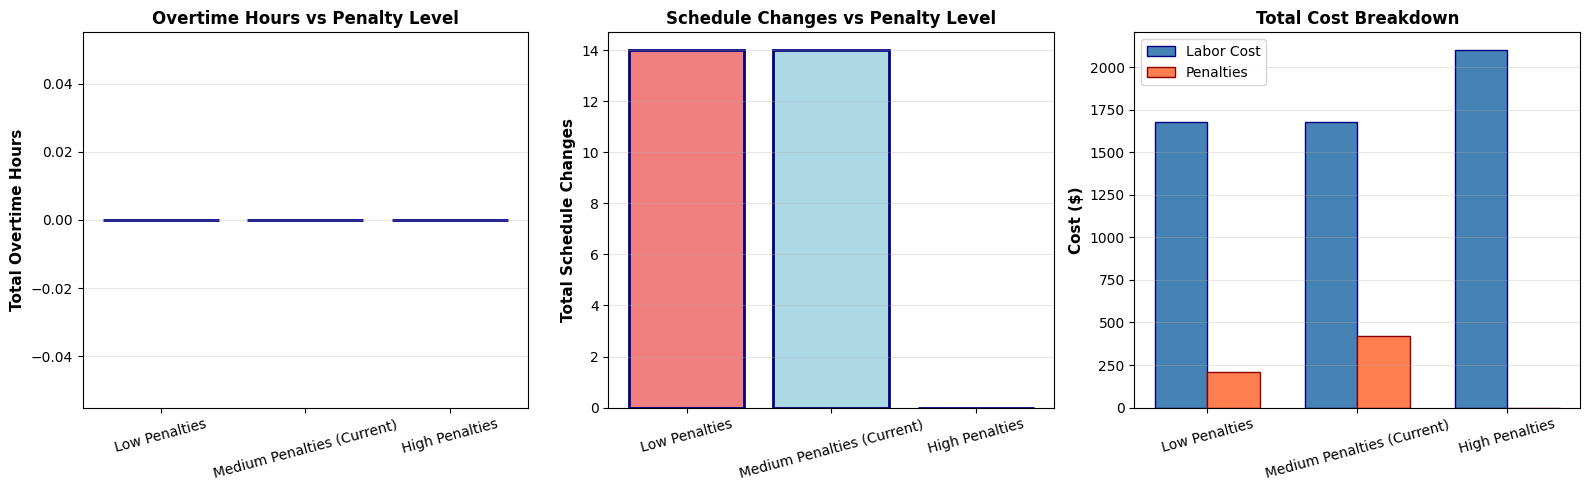


Key Insights:
  - Higher penalties reduce violations but may increase total cost
  - Lower penalties allow more violations but show lower total cost
  - The 'best' penalty depends on how important the preference is
  - Penalties make the tradeoff between preferences and costs visible


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Extract data for visualization
scenarios = [r['Scenario'] for r in comparison_results]
overtime_hours = [r['Total Overtime Hours'] for r in comparison_results]
schedule_changes = [r['Total Schedule Changes'] for r in comparison_results]
total_costs = [float(r['Total Cost'].replace('$', '').replace(',', '')) for r in comparison_results]

# Plot 1: Overtime hours vs penalty
axes[0].bar(scenarios, overtime_hours, color=['lightcoral', 'lightblue', 'lightgreen'], edgecolor='navy', linewidth=2)
axes[0].set_ylabel('Total Overtime Hours', fontsize=11, fontweight='bold')
axes[0].set_title('Overtime Hours vs Penalty Level', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Plot 2: Schedule changes vs penalty
axes[1].bar(scenarios, schedule_changes, color=['lightcoral', 'lightblue', 'lightgreen'], edgecolor='navy', linewidth=2)
axes[1].set_ylabel('Total Schedule Changes', fontsize=11, fontweight='bold')
axes[1].set_title('Schedule Changes vs Penalty Level', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

# Plot 3: Total cost breakdown
x = np.arange(len(scenarios))
width = 0.35
labor_costs = [float(r['Labor Cost'].replace('$', '').replace(',', '')) for r in comparison_results]
penalty_costs = [float(r['Total Penalties'].replace('$', '').replace(',', '')) for r in comparison_results]

axes[2].bar(x - width/2, labor_costs, width, label='Labor Cost', color='steelblue', edgecolor='navy')
axes[2].bar(x + width/2, penalty_costs, width, label='Penalties', color='coral', edgecolor='darkred')
axes[2].set_ylabel('Cost ($)', fontsize=11, fontweight='bold')
axes[2].set_title('Total Cost Breakdown', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(scenarios, rotation=15)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Higher penalties reduce violations but may increase total cost")
print("  - Lower penalties allow more violations but show lower total cost")
print("  - The 'best' penalty depends on how important the preference is")
print("  - Penalties make the tradeoff between preferences and costs visible")


## Summary: Understanding Penalties

**Penalties** are essential for modeling preferences:
- They allow models to violate soft constraints when necessary
- They make tradeoffs explicit and quantifiable
- They help interpret why models choose certain solutions

**Key Takeaways**:
- Penalties don't mean the model failed - they show tradeoffs were made
- Higher penalties mean preferences are more important
- Lower penalties mean preferences are less important
- Understanding penalties helps you interpret and explain model recommendations
